### Mean-Variance Potfolio Optimization with Elastic Net Penalty

TO-DO
- Compare OOS performance of split-bregman using normal params and regularized params
- Compare OOS performance of optimal split bregman against mean variance optimal; equally weighted 


In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [2]:
equity_data=pd.read_csv('../data/equity_data_2010_2020.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])


returns=np.log(equity_data/equity_data.shift(1))
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.5
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.006283,-0.012860,-0.008112,0.000000,-0.024321,0.006161,0.001768,0.005387,0.016313,-0.005385,...,-0.002244,0.000411,0.059041,-0.011930,0.000000,-0.003426,-0.001745,0.031165,0.034651,0.000000
2010-01-06,0.014082,0.000454,0.005538,0.000000,-0.015358,0.010575,-0.005314,-0.002532,-0.002124,-0.002350,...,0.015971,0.003796,-0.013204,0.001919,0.000000,-0.007175,-0.007717,-0.000323,0.083382,0.000000
2010-01-07,0.000717,0.002946,0.008250,0.000000,0.000000,-0.000935,-0.024271,-0.010511,-0.019595,-0.000471,...,-0.002952,0.009377,0.021131,-0.004322,0.000000,-0.000288,-0.025318,0.022681,0.106160,0.000000
2010-01-08,0.007022,0.014602,0.005099,0.000000,-0.020446,-0.003986,-0.008223,-0.012567,-0.005436,-0.001414,...,-0.001109,0.011700,-0.007191,0.000481,0.000000,0.000288,-0.003256,-0.021228,-0.016320,0.000000
2010-01-11,-0.004040,-0.004694,0.005073,0.000000,-0.018394,-0.000940,-0.000918,0.000648,-0.013169,0.004469,...,0.009939,0.004203,-0.003245,0.009574,0.000000,0.017133,0.003256,0.021860,0.006075,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,0.000539,0.003030,-0.000438,0.028495,0.003386,-0.001094,0.005914,-0.001129,0.004828,0.000822,...,-0.000883,-0.003186,-0.005222,0.022329,0.001032,0.001512,0.003197,0.005624,-0.000351,0.020044
2014-12-26,-0.004202,0.007623,0.003277,0.011563,0.004669,-0.000657,0.003434,0.005820,-0.000937,-0.000469,...,-0.000442,0.000428,-0.003518,0.009614,0.004890,0.004797,-0.002941,0.000526,0.001402,0.008178
2014-12-29,0.002703,0.000883,-0.005467,0.002386,-0.004149,-0.008142,-0.002943,-0.005443,-0.007258,-0.003881,...,-0.003320,0.006861,0.017339,0.018150,-0.002313,0.005726,-0.000640,-0.005886,0.005587,-0.004308


### Computation of Naive mean and covariance estimation from sample

In [3]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

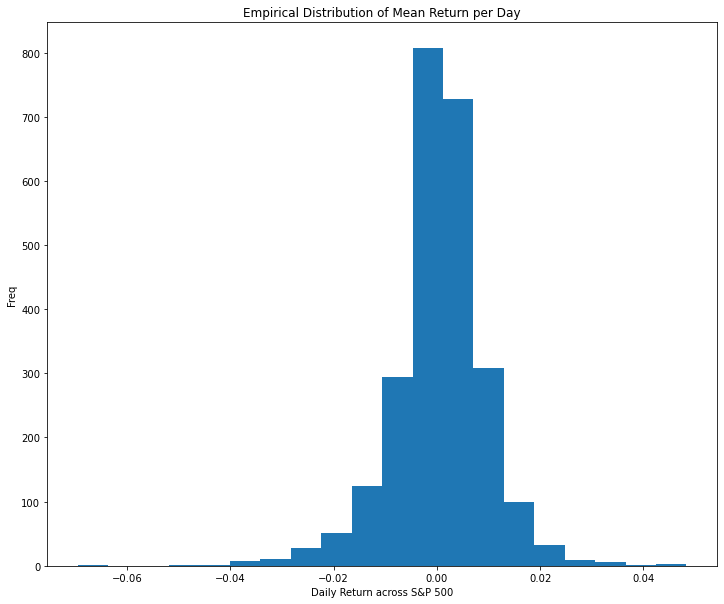

In [4]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

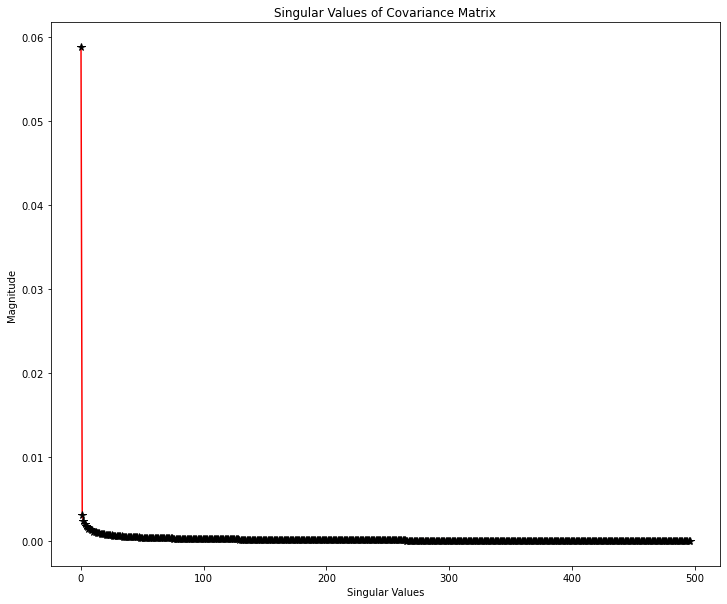

In [5]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Mean and Covariance Estimators 

In [6]:
def james_stein(mu):
    pass


def reg_cov(cov,penalty=0.25):
    return (1-penalty)*cov+penalty*np.identity(cov.shape[0])

returns_cov=reg_cov(returns_cov)

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via constrained minimization and box constraints
    - Solve analytically via closed form solution
- Applies shrinkage (L1) penalty within outer loop


Interesting results in normalization of w vector

In [7]:
def qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol=10e-6,maxiter=25,verbose=True):
    """ Inner optimization problem using unconstrained optimization 
        Approach "numerical" solves numerically via unconstrained minimization
        Approach "closed-form" solves analytically via cvxopt within qpsolvers 
        Support for standard mean variance optimization (approach=2; pen=False)
    """
    
    # reinitialize unit starting point randomly to not get stuck in local minima
    x0=np.random.uniform(-1,1,len(mean))
    x0=x0/np.linalg.norm(x0,ord=1)

    status=None

    if approach=="numerical":
        def objective_val(w,cov,mean,d,b,lambda2):
            obj=np.dot(np.dot(w,cov+lambda2*np.diag(d-b)),w)-np.dot(w,mean)
            
            return obj
        bounds=Bounds(lb,ub)
        lc=LinearConstraint(np.ones(len(mean)),1,1)
        res=minimize(objective_val,x0=x0,args=(cov,mean,d,b,lambda2),method='SLSQP',bounds=bounds,constraints=lc,options={'maxiter':maxiter},tol=tol)
        w=res.x
        status=res.status
        
    if approach=="closed-form":
        w_old=w
        
        # define objective function with l2 penalty
        quad=csc_matrix((cov+lambda2*np.diag(d-b)))
        linear=-1*mean
        
        # constrain solution vector to be unit norm and non-negative
        A=np.ones(len(mean))
        constraint=np.array([1.0])

        # set box constraints
        lb_vec=lb*np.ones(len(mean))
        ub_vec=ub*np.ones(len(mean))

        w = solve_qp(quad,linear.reshape(len(linear),),A=A,b=constraint,initvals=x0, lb=lb_vec,ub=ub_vec,solver="cvxopt")
        status="solved"

        if w is None:
            print("QP Optimization fails, Trying again")
            status="failed"
            return w_old,status
    return w,status

def shrinkage(w,b,lambda1,beta):
    """ Applies one-sided soft-thresholding operator that is equivalent to L1 penalization 
    """
    
    if lambda1==0:
        return np.zeros(len(w))
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,lambda2,lb,ub,beta=None,tol=1e-10,maxiter=100,approach=2,verbose=True):
    """ Split Bregman Optimization Routine
    """

    total_cost=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    i=0
    while total_cost>tol:
        if i>maxiter:
            if verbose:
                print("MaxIter Achieved")
            break
        
        # solve qp problem either closed form or numerically
        w,status=qp(cov,mean,w,d,b,lb,ub,lambda2,approach,tol,maxiter,verbose)
        
        if status=="failed":
            w=w_old
            break
 
        # solve for sparse vector near previous optimal solution
        d=shrinkage(w,b,lambda1,beta)
        b=b+beta*w -d 
        i+=1

        # compute total cost
        total_cost=np.dot(np.dot(w,cov),w)-np.dot(w,mean)+(lambda1*np.sum(np.abs(w))+lambda2*np.sum((w)**2))/2
        if verbose:
            print(f"Total Cost: {total_cost}")
        
        w_old=w

    if sum(abs(w))==0:
        return w,total_cost

    return w, total_cost

### Numerical Results

Unit Tests
- Solve Optimal solution both closed form and numerically


### Test 1: Equal Penalties Closed Form and Numerically

In [8]:
lambda1=1
lambda2=1
w_numerical,error_numerical=split_bregman(returns_cov,returns_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="numerical",verbose=True)
w_numerical

Total Cost: 0.5033254799111155
Total Cost: 0.5034412957046054
Total Cost: 0.5035086319601466
Total Cost: 0.5036159587149867
Total Cost: 0.5037567751620002
Total Cost: 0.5037215920025769
Total Cost: 0.5039590132274664
Total Cost: 0.5038782776937843
Total Cost: 0.5041563958742447
Total Cost: 0.5043801703343122
Total Cost: 0.5043050305535866
Total Cost: 0.5049019102789117
Total Cost: 0.5047458217629817
Total Cost: 0.5047951477414357
Total Cost: 0.5046290222827108
Total Cost: 0.5052948809651057
Total Cost: 0.5052801562715898
Total Cost: 0.50509394928244
Total Cost: 0.5056140875884209
Total Cost: 0.5062603810842875
Total Cost: 0.5063626006658745
Total Cost: 0.5047921654633941
Total Cost: 0.5050522187856514
Total Cost: 0.5053628571475294
Total Cost: 0.5051592467339602
Total Cost: 0.5054575249444052
MaxIter Achieved


array([ 1.73874811e-03,  3.44866198e-03,  1.57777495e-03,  1.94175440e-03,
        3.93201075e-03,  1.88321652e-03,  1.53558130e-03,  1.29951554e-03,
        1.58004678e-03,  2.00979856e-03,  3.95062442e-03,  2.10930589e-04,
        5.84987274e-04,  1.26592276e-03,  1.38582994e-03,  1.99971067e-03,
        6.05147576e-03,  1.00575941e-03,  9.00493587e-04,  2.60536903e-03,
        8.69686618e-04,  2.06909380e-03,  2.07363575e-03,  1.36592865e-03,
        1.35203114e-03,  2.61901068e-03,  2.03821898e-03,  1.44698951e-03,
       -1.42633929e-03,  1.45296038e-03,  9.16119339e-03,  1.58506449e-03,
        1.90851813e-03,  1.33158875e-03,  2.18871141e-03,  2.30668859e-03,
        2.75520095e-03,  3.48658508e-03,  2.76028947e-03,  2.65414122e-03,
        1.96773189e-03,  1.36328392e-03,  1.47331531e-03,  2.31439889e-03,
       -5.80342862e-04,  3.63626015e-03,  1.30458720e-03,  3.70898009e-03,
        2.37955001e-03,  8.54690466e-04,  1.96434734e-03,  2.03507170e-03,
        7.64130667e-04,  

In [10]:
lambda1=1
lambda2=1
w_cf,error_cf=split_bregman(returns_cov,returns_mean,lb=-0.05,ub=0.1,lambda1=lambda1,lambda2=lambda2,tol=1e-6,maxiter=25,approach="closed-form",verbose=True)
w_cf

Total Cost: 0.5245946226537935
Total Cost: 0.5253737854980115
Total Cost: 0.5264160056099674
Total Cost: 0.5275530358919955
Total Cost: 0.528820288362581
Total Cost: 0.530174481577575
Total Cost: 0.5315755322360614
Total Cost: 0.5330424703968928
Total Cost: 0.5345959635532608
Total Cost: 0.5363265753994361
Total Cost: 0.5382414863502291
Total Cost: 0.5403239096878614
Total Cost: 0.5426399603187404
Total Cost: 0.5453513283711159
Total Cost: 0.5486945897703386
Total Cost: 0.553481483728345
Total Cost: 0.5700745666717054
QP Optimization fails, Trying again


array([ 1.35865312e-03,  4.29070458e-03,  9.71968072e-04,  1.40388727e-03,
        5.09371883e-03,  1.62638605e-03,  1.00279624e-03,  6.77386753e-04,
        1.22118526e-03,  1.86378310e-03,  4.83883257e-03, -9.88443822e-04,
       -3.18161282e-04,  8.05838991e-04,  8.34346650e-04,  1.98478680e-03,
        8.93021464e-03,  3.28699425e-04,  5.41546953e-05,  2.95587094e-03,
       -2.68708095e-04,  1.87626683e-03,  1.98052171e-03,  7.66347940e-04,
        7.44270826e-04,  2.52981396e-03,  1.89063197e-03,  5.90572857e-04,
       -4.18340941e-03,  8.21545139e-04,  1.73283323e-02,  1.02430207e-03,
        1.81751471e-03,  9.18886816e-04,  1.97659209e-03,  2.22480436e-03,
        3.37570725e-03,  3.95271959e-03,  3.14618119e-03,  2.84961393e-03,
        1.90475356e-03,  8.24614747e-04,  1.00652089e-03,  2.35679714e-03,
       -2.39051334e-03,  4.26713474e-03,  7.60659015e-04,  4.14522426e-03,
        2.40904768e-03, -3.75024765e-04,  1.66166950e-03,  1.89348595e-03,
       -3.20164683e-04,  

### Comparisons of Optimal Solution

[  0   1   2   3   4   5   6   7   8   9  10  13  14  15  16  17  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  45  46  47  48  50  51  53  54  55  56  59  61  63  64
  68  71  72  73  74  75  76  77  78  79  81  83  85  86  87  89  90  91
  92  93  94  95  96  98  99 101 102 103 104 105 106 107 108 112 114 115
 116 117 118 120 121 122 123 124 125 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 143 144 146 147 148 149 150 151 152 153 155 156 159
 160 161 162 163 164 165 166 167 169 171 172 173 174 175 176 177 178 180
 181 182 184 186 188 189 190 191 192 193 194 196 197 198 199 201 203 208
 209 211 212 213 214 216 217 218 219 222 223 224 225 226 227 230 231 232
 233 234 235 238 239 240 242 243 244 245 246 248 249 250 251 252 253 254
 255 257 258 259 260 262 263 267 268 269 270 271 272 273 275 277 278 280
 282 283 284 285 286 287 289 291 292 294 295 296 297 299 300 301 302 303
 304 305 306 307 309 310 311 312 313 314 316 317 31

Text(0, 0.5, 'Weight Allocation')

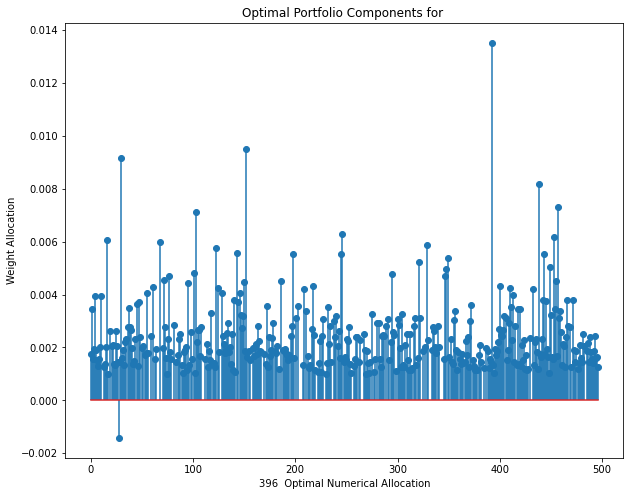

In [11]:
threshold=0.001

optimal_numerical=np.where(abs(w_numerical)>threshold)[0]
print(optimal_numerical)

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")

ax.stem(optimal_numerical,w_numerical[optimal_numerical],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_numerical)}  Optimal Numerical Allocation")

ax.set_ylabel("Weight Allocation")

[ 30 103 152 392 438 457]


Text(0, 0.5, 'Weight Allocation')

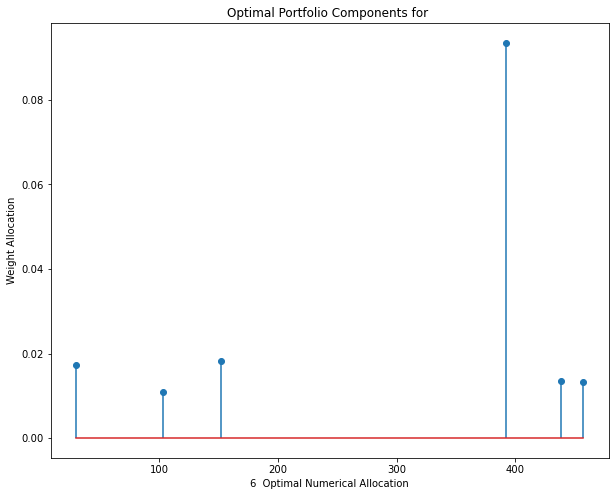

In [12]:
threshold=0.01

optimal_cf=np.where(abs(w_cf)>threshold)[0]
print(optimal_cf)

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Optimal Portfolio Components for ")

ax.stem(optimal_cf,w_cf[optimal_cf],markerfmt='o',use_line_collection=True)
ax.set_xlabel(f"{len(optimal_cf)}  Optimal Numerical Allocation")

ax.set_ylabel("Weight Allocation")

### Grid Search for Optimal Lambda Values 
- Cross valaidate optimal $\lambda_1$ and $\lambda_2$ parameters representing L1 and L2 regularization

In [13]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    """ Grid Search for optimal lambda1 and lambda2 under constrained portfolio problem 
    """
    results={}
    for i in params:
        lambda1,lambda2=i
        lb,ub=0,1
        w,error=split_bregman(returns_cov,returns_mean,lambda1,lambda2,lb=lb,ub=ub,tol=tol,maxiter=maxiter,approach="closed-form",verbose=False)
        print(f" lambda1: {np.round(lambda1,4)} lambda2: {np.round(lambda2,4)} error: {np.round(error,8)}")
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda1_grid=np.geomspace(0.0001,100,5)
lambda2_grid=np.geomspace(0.0001,100,5)

params=[]
for i in itertools.product(lambda1_grid,lambda2_grid):
    params.append(i)

sorted_dict=grid_search(params,returns_mean,returns_cov)

 lambda1: 0.0001 lambda2: 0.0001 error: 4.003e-05
 lambda1: 0.0001 lambda2: 0.0032 error: 4.504e-05
 lambda1: 0.0001 lambda2: 0.1 error: 0.00021006
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 3.1623 error: 0.00830669
QP Optimization fails, Trying again
 lambda1: 0.0001 lambda2: 100.0 error: 0.15139269
 lambda1: 0.0032 lambda2: 0.0001 error: 0.00157117
 lambda1: 0.0032 lambda2: 0.0032 error: 0.00157618
 lambda1: 0.0032 lambda2: 0.1 error: 0.00174119
QP Optimization fails, Trying again
 lambda1: 0.0032 lambda2: 3.1623 error: 0.00983783
QP Optimization fails, Trying again
 lambda1: 0.0032 lambda2: 100.0 error: 0.15292383
 lambda1: 0.1 lambda2: 0.0001 error: 0.04999003
 lambda1: 0.1 lambda2: 0.0032 error: 0.04999504
 lambda1: 0.1 lambda2: 0.1 error: 0.05016006
QP Optimization fails, Trying again
 lambda1: 0.1 lambda2: 3.1623 error: 0.05825669
QP Optimization fails, Trying again
 lambda1: 0.1 lambda2: 100.0 error: 0.20134269
 lambda1: 3.1623 lambda2: 0.0001 error: 1.581128

Text(0, 0.5, 'Weight Allocation')

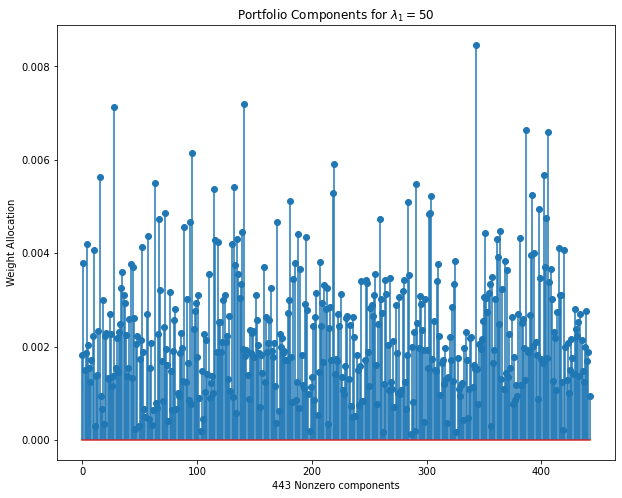

In [16]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0.0001)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [17]:
print(f"Largest Component is {max(abs(wi[nonzero_wi]))}")
print(f"Smallest Component is {min(abs(wi[nonzero_wi]))}")

Largest Component is 0.008464706977783931
Smallest Component is 0.00013115620470939866


### Optimally tuned penalty compared to equal weighted and mean variance optimized

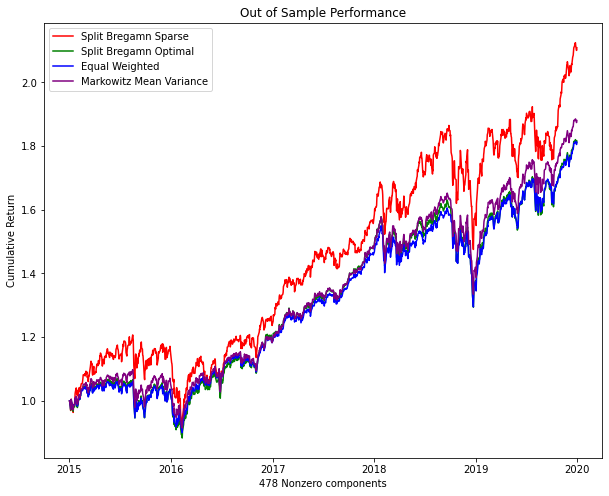

In [482]:
cum_returns_split_i=np.cumprod(1+np.dot(w2,returns_test.T))
cum_returns_split_j=np.cumprod(1+np.dot(wi,returns_test.T))
cum_returns_split_opt=np.cumprod(1+np.dot(w_opt,returns_test.T))


equal=(1/returns_test.shape[1])*np.ones(returns_test.shape[1])
cum_returns_equal=np.cumprod(1+np.dot(equal,returns_test.T))
fig,ax=plt.subplots(figsize=(10,8))
plt.title("Out of Sample Performance")
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_i,label='Split Bregamn Sparse',color='red')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_j,label='Split Bregamn Optimal',color='green')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_equal,label='Equal Weighted',color='blue')
plt.plot(pd.to_datetime(returns_test.index),cum_returns_split_opt,label='Markowitz Mean Variance',color='purple')
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Cumulative Return")
plt.legend()


In [480]:
def get_sharpe(port_returns,rf=0.0178):
    sd=np.std(port_returns)*np.sqrt(252)
    mu=np.mean(port_returns)*252
    
    sharpe=(mu-rf)/sd
    
    return sharpe

In [484]:
print(f"Sharpe of equal allocation is {round(get_sharpe(np.dot(equal,returns_test.T)),2)}")
print(f"Sharpe of Mean Variance allocation is {round(get_sharpe(np.dot(w_opt,returns_test.T)),2)}")
print(f"Sharpe of Split-Bregman Optimal allocation is {round(get_sharpe(np.dot(wi,returns_test.T)),2)}")
print(f"Sharpe of Split-Bregman Sparse allocation is {round(get_sharpe(np.dot(w1,returns_test.T)),2)}")


Sharpe of equal allocation is 0.83
Sharpe of Mean Variance allocation is 0.86
Sharpe of Split-Bregman Optimal allocation is 0.79
Sharpe of Split-Bregman Sparse allocation is 0.53
